In [4]:
# reweight limit from 3 decay mode to compare with ATLAS limit

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2


# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [5]:
import pickle

with open('dddd.pickle', 'rb') as handle:
     limit_4d= pickle.load(handle)
with open('4Tau.pickle', 'rb') as handle:
     limit_4Tau= pickle.load(handle)

with open('bbbb.pickle', 'rb') as handle:
     limit_4b= pickle.load(handle)



dict_keys([15, 40, 55])

In [17]:
# branching ratio ATLAS used for bb, cc, tautau, https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/EXOT-2017-05/tabaux_02.png
#mumu is ignored because we are not sensitive to that, but small anyways

br = {
7: [0,0.69,0.31],
15: [0.79,0.14,0.07],
40: [0.87,0.08,0.04],
55: [0.87,0.08,0.04],

}

In [18]:
# reweight
limits = {}
for k, v in limit_4d.items():

#     if k == 55:continue
    if k == 7:limits[k] = br[k][1] * limit_4d[k] + br[k][2] * limit_4Tau[k]
    else: limits[k] = br[k][0]* limit_4b[k] + br[k][1] * limit_4d[k] + br[k][2] * limit_4Tau[k]
    print(len(limits[k]))
# ctaus = np.array([10, 20, 30, 40, 50, 60, 100, 200, 300, 500, 1000, 2000, 3000, 5000, 10000, 20000, 30000, 50000, 100000,int(2e5),int(3e5),int(5e5), \
#                         int(2e6),int(3e6),int(5e6),int(1e7)])
ctaus = np.array([10, 20, 30, 40, 50, 60, 100, 125, 200, 300, 500, 600,700,800, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 20000, 30000, 100000,int(2e5),int(3e5),\
                       int(3e6),int(5e6),int(1e7)]) #v13
mass = np.array([ 7, 15, 40, 55])
print(len(ctaus))

31
31
31
31
31


In [8]:


dc_version = 'v13'

methodA = False
# unblind = 'unblindABC'
unblind = 'unblind'
hybridNew = 1

bdt_name = 'cut_based_v4'
version = '/V1p17/v2/v106/'
mode = 'allProd_withggZH'


nrechit = 130
dphi = 'dPhiCluster0p75'



# load atlas limit

In [11]:
file_dir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'

exo_19_021_bb55 = file_dir + 'exo-19-021_bb_55.csv'
exo_19_021_bb40 = file_dir + 'exo-19-021_bb_40.csv'
exo_19_021_dd55 = file_dir + 'exo-19-021_dd_55.csv'
exo_19_021_dd40 = file_dir + 'exo-19-021_dd_40.csv'
exo_19_021_dd15 = file_dir + 'exo-19-021_dd_15.csv'


# took from paper draft v5
exo_20_003_bb55 = file_dir + 'exo-20-003_bb_55.csv'
exo_20_003_bb40 = file_dir + 'exo-20-003_bb_40.csv'
exo_20_003_bb15 = file_dir + 'exo-20-003_bb_15.csv'
exo_20_003_dd55 = file_dir + 'exo-20-003_dd_55.csv'
exo_20_003_dd40 = file_dir + 'exo-20-003_dd_40.csv'
exo_20_003_dd15 = file_dir + 'exo-20-003_dd_15.csv'


ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
ms_8 = file_dir + 'atlas_mh125_mx8_ms.csv'

ms_2tag_55 = file_dir + 'atlas_2tag_55.csv'
ms_2tag_35 = file_dir + 'atlas_2tag_35.csv'
ms_2tag_15 = file_dir + 'atlas_2tag_15.csv'
ms_2tag_5 = file_dir + 'atlas_2tag_5.csv'


other_limits = {}

other_limits['atlas_ms_40'] = np.genfromtxt(ms_40, delimiter=',')
other_limits['atlas_ms_15'] = np.genfromtxt(ms_15, delimiter=',')
other_limits['atlas_ms_8'] = np.genfromtxt(ms_8, delimiter=',')

other_limits['ms_2tag_55'] = np.genfromtxt(ms_2tag_55, delimiter=',')
other_limits['ms_2tag_35'] = np.genfromtxt(ms_2tag_35, delimiter=',')
other_limits['ms_2tag_15'] = np.genfromtxt(ms_2tag_15, delimiter=',')
other_limits['ms_2tag_5'] = np.genfromtxt(ms_2tag_5, delimiter=',')


# 'ms1_40' = np.genfromtxt(ms1_40, delimiter=',')
# 'ms2_40' = np.genfromtxt(ms2_40, delimiter=',')
# 'id55' = np.genfromtxt(id55, delimiter=',')
# 'comb40' = np.genfromtxt(comb40, delimiter=',')
other_limits['exo_19_021_bb55'] = np.genfromtxt(exo_19_021_bb55, delimiter=',')
other_limits['exo_19_021_bb40'] = np.genfromtxt(exo_19_021_bb40, delimiter=',')
other_limits['exo_19_021_dd55'] = np.genfromtxt(exo_19_021_dd55, delimiter=',')
other_limits['exo_19_021_dd40'] = np.genfromtxt(exo_19_021_dd40, delimiter=',')
other_limits['exo_19_021_dd15'] = np.genfromtxt(exo_19_021_dd15, delimiter=',')

# other_limits['exo_20_003_bb55'] = np.genfromtxt(exo_20_003_bb55, delimiter=',')
# other_limits['exo_20_003_bb40'] = np.genfromtxt(exo_20_003_bb40, delimiter=',')
other_limits['exo_20_003_bb15'] = np.genfromtxt(exo_20_003_bb15, delimiter=',')
# other_limits['exo_20_003_dd55'] = np.genfromtxt(exo_20_003_dd55, delimiter=',')
# other_limits['exo_20_003_dd40'] = np.genfromtxt(exo_20_003_dd40, delimiter=',')
# other_limits['exo_20_003_dd15'] = np.genfromtxt(exo_20_003_dd15, delimiter=',')





In [12]:
print(mass)

[ 7 15 40 55]


# comparison with ALTAS (all masses)

[1.00e-02 2.00e-02 3.00e-02 4.00e-02 5.00e-02 6.00e-02 1.00e-01 1.25e-01
 2.00e-01 3.00e-01 5.00e-01 6.00e-01 7.00e-01 8.00e-01 1.00e+00 2.00e+00
 3.00e+00 4.00e+00 5.00e+00 6.00e+00 7.00e+00 8.00e+00 1.00e+01 2.00e+01
 3.00e+01 1.00e+02 2.00e+02 3.00e+02 3.00e+03 5.00e+03 1.00e+04]
[1.18996903e+00 5.60413471e-02 1.66749237e-02 9.55479454e-03
 6.42394994e-03 5.03540447e-03 3.02723580e-03 2.56426090e-03
 2.46128625e-03 2.71323066e-03 2.93642626e-03 3.16042186e-03
 3.46482419e-03 3.97522167e-03 8.15479250e-03 1.13163897e-02
 1.46553365e-02 1.77849214e-02 2.10386473e-02 2.38717075e-02
 2.74590667e-02 6.91921817e-02 1.01613656e-01 3.15263431e-01
 6.41040541e-01 9.53582019e-01 9.56170477e+00 1.59834421e+01
 3.21947185e+01]
[2.53615692e+02 1.82428114e+00 2.28088495e-01 7.16388187e-02
 3.39441112e-02 1.95723178e-02 6.72230356e-03 5.21277228e-03
 3.22478744e-03 2.45702437e-03 2.03506582e-03 2.07969973e-03
 2.08353901e-03 2.14278676e-03 3.37084951e-03 4.41497544e-03
 5.48750627e-03 6.78341916e-

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


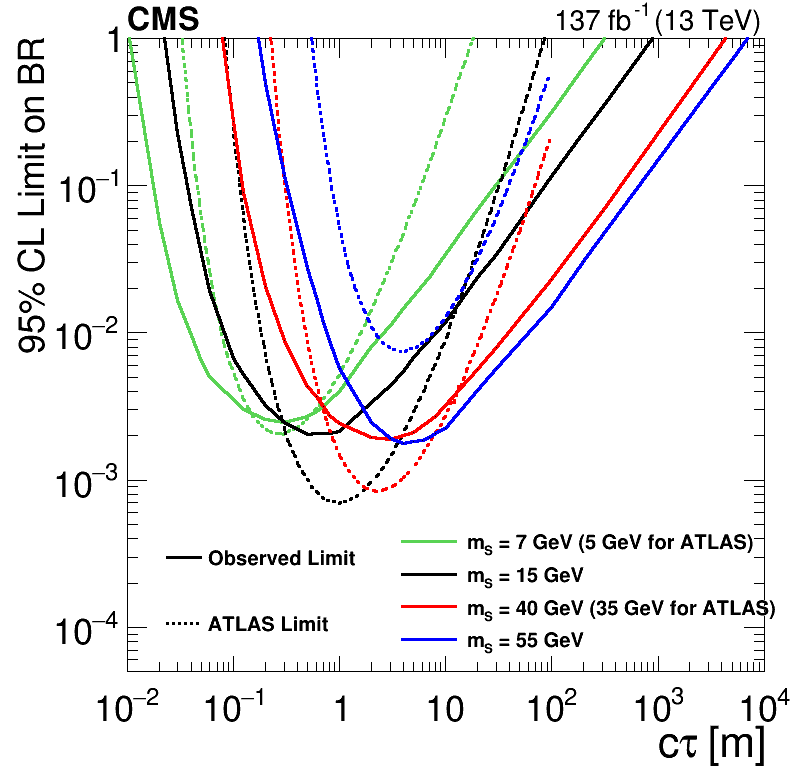

In [27]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   

leg = rt.TLegend(0.49,0.15,0.88,0.32)

leg.SetTextSize(0.028)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.005)

leg2 = rt.TLegend(0.2,0.15,0.45,0.32)
leg2.SetTextSize(0.028)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
print(ctaus_m)
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
h_others = {}
upper = 1000000

if withATLAS:
    
    h_others[7] = create_TGraph(other_limits['ms_2tag_5'][:,0][other_limits['ms_2tag_5'][:,1]<upper],other_limits['ms_2tag_5'][:,1][other_limits['ms_2tag_5'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_others[15] = create_TGraph(other_limits['ms_2tag_15'][:,0][other_limits['ms_2tag_15'][:,1]<upper],other_limits['ms_2tag_15'][:,1][other_limits['ms_2tag_15'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_others[40] = create_TGraph(other_limits['ms_2tag_35'][:,0][other_limits['ms_2tag_35'][:,1]<upper],other_limits['ms_2tag_35'][:,1][other_limits['ms_2tag_35'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_others[55] = create_TGraph(other_limits['ms_2tag_55'][:,0][other_limits['ms_2tag_55'][:,1]<upper],other_limits['ms_2tag_55'][:,1][other_limits['ms_2tag_55'][:,1]<upper],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#         for k, v in h_others.items():
#             leg.AddEntry(h_others[k], "ATLAS MS (36 fb^{-1})", 'L')


for i, m in enumerate(mass):
#     if m == 55:continue
    cond = limits[m][:,5] < upper
    if m == 7:
        cond = np.logical_and(cond, np.logical_not(ctaus_m==10))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==0.1))
    if m == 15:
        cond = np.logical_and(cond, np.logical_not(ctaus_m==0.7))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
                
    if m == 40:
        cond = np.logical_and(cond, np.logical_not(ctaus_m==7))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==6))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==4))
        cond = np.logical_and(cond, np.logical_not(ctaus_m==10))


    h_obs[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#     print(m)
#     print(ctaus_m[cond])
    print(limits[m][:,5][cond])
    if m == 7:leg.AddEntry(h_obs[m], "m_{S} = "+str(m)+" GeV (5 GeV for ATLAS)", "L")
    elif m == 40:leg.AddEntry(h_obs[m], "m_{S} = "+str(m)+" GeV (35 GeV for ATLAS)", "L")
    else: leg.AddEntry(h_obs[m], "m_{S} = "+str(m)+" GeV", "L")
    if m == 15:
        leg2.AddEntry(h_obs[m], "Observed Limit", "LP")
        leg2.AddEntry(h_others[m], "ATLAS Limit", "L")


    if len(mass) == 3: 
        if not m == 55:h_others[m].SetLineColor(std_color_list[i])
        h_obs[m].SetLineColor(std_color_list[i])
#         h_obs[m].SetMarkerColor(std_color_list[i])


    else: 
        if i == 0:
            h_others[m].SetLineColor(std_color_list[3])
            h_obs[m].SetLineColor(std_color_list[3])
            h_obs[m].SetMarkerColor(std_color_list[3])
        else: 
                
            h_others[m].SetLineColor(std_color_list[i-1])
            h_obs[m].SetLineColor(std_color_list[i-1])
#             h_obs[m].SetMarkerColor(std_color_list[i-1])
    h_obs[m].SetLineWidth(3)
    if not m == 550:
        h_others[m].SetLineStyle(2)
        h_others[m].SetLineWidth(3)
        h_others[m].GetXaxis().SetLimits(0.01,10000.0)
#         h_others[m].GetYaxis().SetRangeUser(5e-4,100)
        h_others[m].GetYaxis().SetRangeUser(5e-5,1.0)


        h_others[m].GetXaxis().SetTitleOffset(1)
        h_others[m].GetYaxis().SetTitleSize(0.05)
        h_others[m].GetYaxis().SetTitleOffset(1.5)



for i,m in enumerate(h_obs.keys()):
    if not m == 550:
        h_others[m].Draw('LA' if i == 0 else 'Lsame')
    h_obs[m].Draw('LPsame')



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText =0
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
CMS_lumi.CMS_lumi(c, 4, iPos)

leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo_'+dphi+'_nRechit'+str(nrechit)+'_observed_withATLAS_reweight'
# if hybridNew:name += '_hybridNew'
# if CMS_lumi.writeExtraText: name += "_pas"



# c.SaveAs(name+'.png')
# c.SaveAs(name+'.C')
# c.SaveAs(name+'.pdf')

tdrstyle.setTDRStyle()
c.Draw()
